# Coronavirus Tweet NLP

Data:[Kaggle](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification)

## Content

- [Environment](#1.-Environment)
- [Data](#2.-Data)
- [EDA](#3.-EDA)
- [Word Cloud](#4.-Word-Cloud)
- [Sentiment Ananysis](#5.-Sentiment-Analysis)
- [Word2Vec](#6.-Word2Vec)
- [LDA](#7.-LDA)

## 1. Environment

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from nrclex import NRCLex
from nltk.corpus import opinion_lexicon

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from matplotlib import cm
from sklearn.metrics import confusion_matrix, accuracy_score

from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import LatentDirichletAllocation

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

## 2. Data

In [2]:
## Cleaned data

df = pd.read_csv('../data/Corona_NLP_filtered.csv')
df = df.dropna()
df.Word_list = df.Word_list.apply(eval)
df.head()

,Unnamed: 0,OriginalTweet,Sentiment,Tweet_filtered,Word_list,Senten_list,Senten_list_filtered
0,0,advice Talk to your neighbours family to excha...,Positive,advice talk neighbour family exchange phone nu...,"[advice, talk, neighbour, family, exchange, ph...",['advice Talk to your neighbours family to exc...,['advice talk to your neighbours family to exc...
1,1,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworth give elderly d...,"[coronavirus, australia, woolworth, give, elde...",['Coronavirus Australia: Woolworths to give el...,['coronavirus australia woolworths to give eld...
2,2,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...,"[food, stock, one, empty, please, dont, panic,...",['My food stock is not the only one which is e...,['my food stock is not the only one which is e...
3,3,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket covid outbreak im paranoi...,"[ready, go, supermarket, covid, outbreak, im, ...","['Me, ready to go at supermarket during the #C...",['me ready to go at supermarket during the cov...
4,4,As news of the regionÂs first confirmed COVID...,Positive,news regionâ  first confirmed covid case came...,"[news, regionâ, , first, confirmed, covid, ca...",['As news of the regionÂ\x92s first confirmed ...,['as news of the regionâ\x92s first confirmed ...


In [3]:
df.shape

(44249, 7)

## 3. EDA

- [Target Distribution](#Target-Distribution)
- [Sentence Length](#Sentence-Length(Number-of-Words))

### Target Distribution

In [4]:
target = df.Sentiment.value_counts()
target

Positive              12240
Negative              10852
Neutral                7902
Extremely Positive     7204
Extremely Negative     6051
Name: Sentiment, dtype: int64

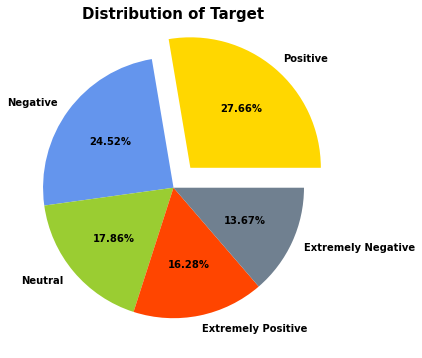

In [5]:
font = {'fontsize':15, 'fontweight':'bold'}
font1 = {'fontsize':12, 'fontweight':'bold'}
font2 = {'fontsize':10, 'fontweight':'bold'}
colors = ['gold', 'cornflowerblue', 'yellowgreen', 'orangered', 'slategrey']

fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.pie(x = target, explode = (0.2,0,0,0,0),labels = target.index, 
        autopct = '%.2f%%', colors = colors, textprops=font2);
plt.title('Distribution of Target', fontdict= font);

### Sentence Length(Number of Words)

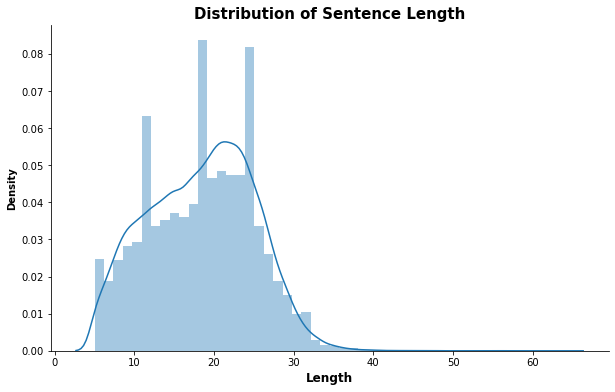

In [6]:
df['Sentence_len'] = df.Word_list.apply(lambda x:len(x))

fig, ax = plt.subplots(1, 1, figsize = (10,6))
sns.distplot(x = df.Sentence_len, bins = 50);
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Distribution of Sentence Length', fontdict=font);
plt.xlabel('Length', fontdict=font1);
plt.ylabel('Density', fontdict=font2);

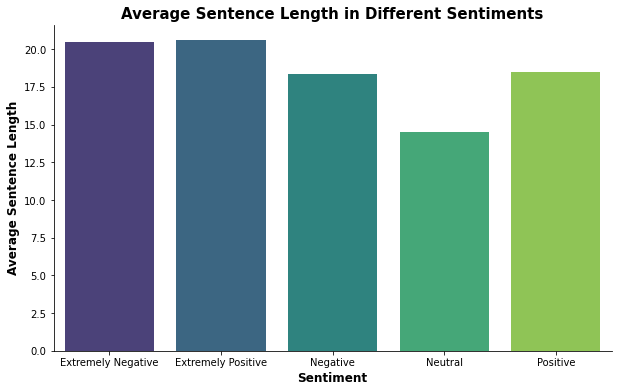

In [7]:
## Different sentiments
sentence_lenq_sent = df.groupby('Sentiment').Sentence_len.mean()

fig, ax = plt.subplots(1, 1, figsize = (10,6))
sns.barplot(x = sentence_lenq_sent.index, y = sentence_lenq_sent.values, palette='viridis');
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Average Sentence Length in Different Sentiments', fontdict=font);
plt.xlabel('Sentiment', fontdict=font1);
plt.ylabel('Average Sentence Length', font1);

## 4. Word Cloud

In [8]:
## The whole data

cv = CountVectorizer(min_df=10, max_df=.3, stop_words = 'english')
df_cv = cv.fit_transform(df['Tweet_filtered'])
word_count = df_cv.sum(axis = 0)
word_freq = [(word, word_count[0, idx]) for word, idx in cv.vocabulary_.items()]
word_freq = sorted(word_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(background_color='white',
                      width = 1000, height = 1000).generate_from_frequencies(dict(word_freq))

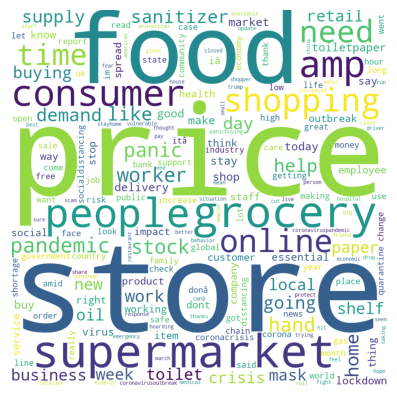

In [9]:
plt.figure(figsize=(5,5), dpi = 100)
plt.axis('off')
plt.imshow(wordcloud)
plt.show();

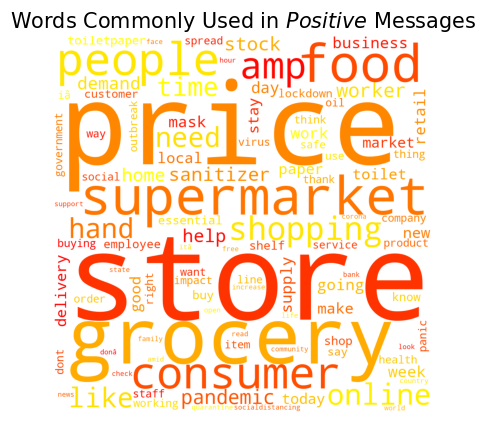

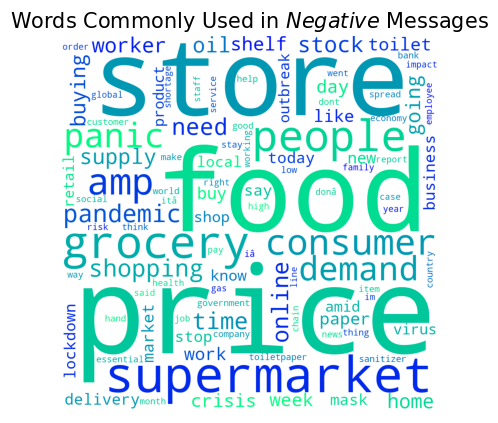

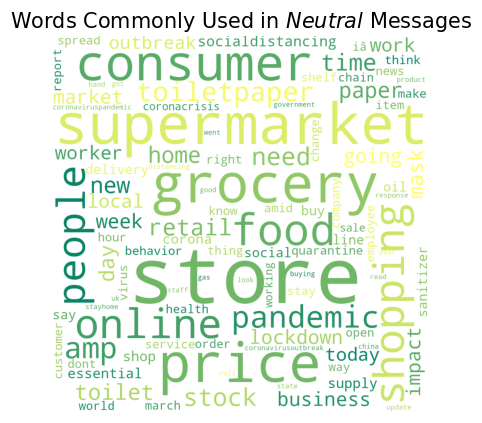

In [4]:
## Different sentiments

def classes_def(x):
    if x ==  'Extremely Positive' or x == 'Positive':
        return "Positive"
    elif x == "Extremely Negative" or x == 'Negative':
        return "Negative"
    else:
        return "Neutral"
    
df['Sentiment_3'] = df['Sentiment'].apply(lambda x: classes_def(x))

for label, cmap in zip(['Positive', 'Negative', 'Neutral'],
                       ['autumn', 'winter', 'summer']):
    sep = df[df['Sentiment'] == label]['Tweet_filtered']
    cv = CountVectorizer(min_df=10, max_df=.3, stop_words='english')
    sep_cv = cv.fit_transform(sep)
    word_count = sep_cv.sum(axis = 0)
    word_freq = [(word, word_count[0, idx]) for word, idx in cv.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse = True)
    
    plt.figure(figsize=(5, 5), dpi = 100)
    wc = WordCloud(width=1000, height=1000, background_color='white', colormap=cmap, max_words=100)
    wc.generate_from_frequencies(dict(word_freq))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Messages", size=15)
    plt.show()

## 5. Sentiment Analysis

- [NCR Lexicon](#NCR-Lexicon(6-emotions))
- [Bing Liu Lexicon](#Bing-Liu-Lexicon)
- [Classification](#Classification)

### NCR Lexicon(6 emotions)

trust, anticipation, joy, surprise, anger, disgust, fear, sadness 

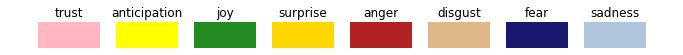

In [11]:
emotions_color = {"trust" : "lightpink", "anticipation" : "yellow", "joy" : "forestgreen", "surprise" : "gold", 
                 "anger" : "firebrick", "disgust" : "burlywood", "fear" : "midnightblue", "sadness" : "lightsteelblue"}

plt.figure(figsize=(12,0.5))
my_bars = plt.bar(list(emotions_color),8*[1],color=emotions_color.values())
for i,bar in enumerate(my_bars):
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.2, list(emotions_color)[i],
                 ha='center', fontsize=12)
plt.axis("off")
plt.show();

In [12]:
## Concat every 10 rows

i = 0
sentences = []
while i < df.shape[0]:
    sentences.append(' '.join(df.Tweet_filtered.iloc[i:i+10]))
    i = i+10
    
# Emotions
sequence_of_emotions_level = []
sequence_of_emotions_color = []
emotion_list = []

for sentence in sentences:
    emotions = NRCLex(sentence)
    emotion_frequencies = emotions.affect_frequencies
    
    emotion_frequencies.pop("positive",None)
    emotion_frequencies.pop("negative",None)
    top_emotion = max(emotion_frequencies,key=emotion_frequencies.get)
    
    emotion_list.append(top_emotion)
    sequence_of_emotions_level.append(emotion_frequencies[top_emotion])
    sequence_of_emotions_color.append(emotions_color[top_emotion])

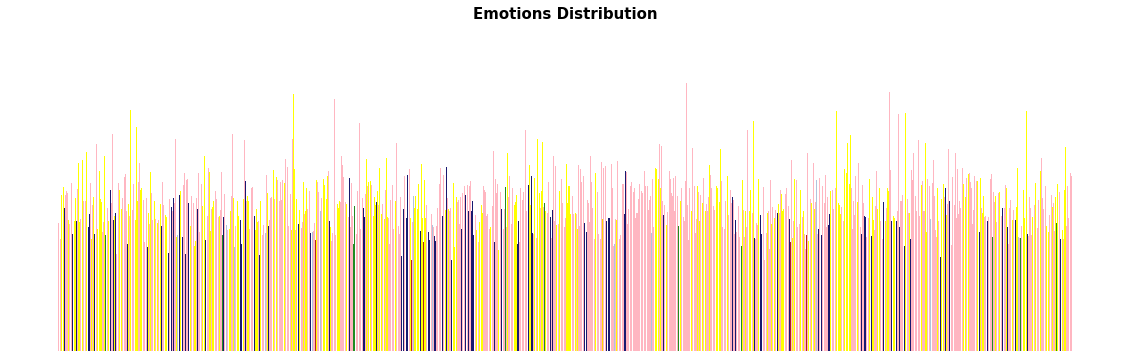

In [13]:
# plot

plt.figure(figsize=(20, 6))
plt.bar(range(len(sentences)), sequence_of_emotions_level, color=sequence_of_emotions_color)
frame1 = plt.gca()
frame1.axis('off')
plt.title('Emotions Distribution', fontdict=font)
plt.show();

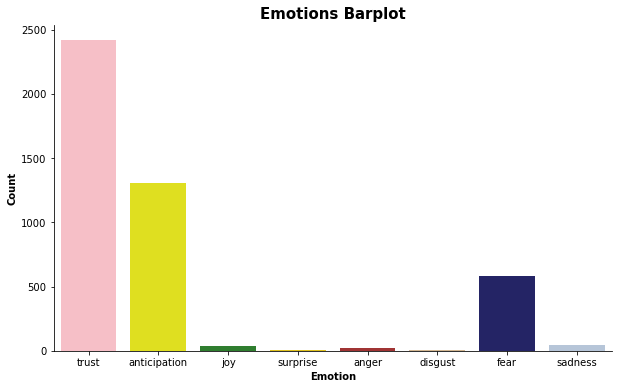

In [14]:
plt.figure(figsize=(10,6))
sns.countplot(x = emotion_list, palette=list(emotions_color.values()), 
              order = list(emotions_color.keys()));
plt.title('Emotions Barplot', fontdict=font);
plt.xlabel('Emotion', fontdict=font2);
plt.ylabel('Count', fontdict=font2);
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show();

### Bing Liu Lexicon

In [15]:
positive = set(opinion_lexicon.positive())
negative = set(opinion_lexicon.negative())

In [16]:
## For each doc, calculate the score

df['Positive'] = df.Word_list.apply(lambda x: list(positive.intersection(set(x))))
df['Negative'] = df.Word_list.apply(lambda x: list(negative.intersection(set(x))))
df['Sentiment_Score'] = df.apply(lambda x: len(x.Positive) - len(x.Negative), axis=1)

sentiment_score = list(df.Sentiment_Score[df.Sentiment_Score != 0])

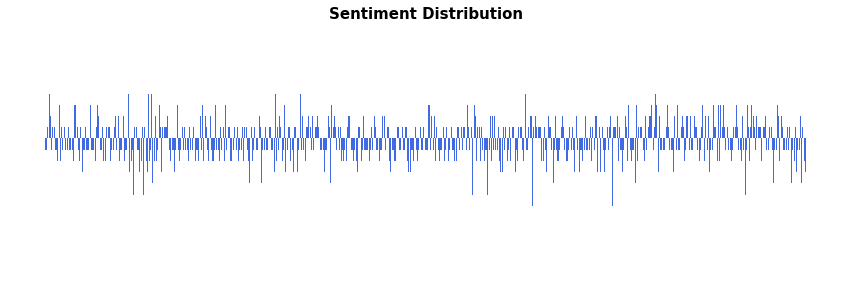

In [17]:
plt.figure(figsize=(15, 5))
plt.bar(range(len(sentiment_score)), sentiment_score, color = 'royalblue')
frame1 = plt.gca()
frame1.axis('off')
plt.title('Sentiment Distribution', fontdict=font)
plt.show();

In [18]:
## Every 10 doc
word_list = []
i = 0
while i < df.shape[0]:
    word_list.append(sum(df.Word_list[i:i+10].to_list(),[]))
    i = i+10

sentiment_score_10 = []
for l in word_list:
    score = 0
    for word in l:
        if word in positive:
            score += 1
        elif word in negative:
            score -= 1
        else:
            continue
    sentiment_score_10.append(score)

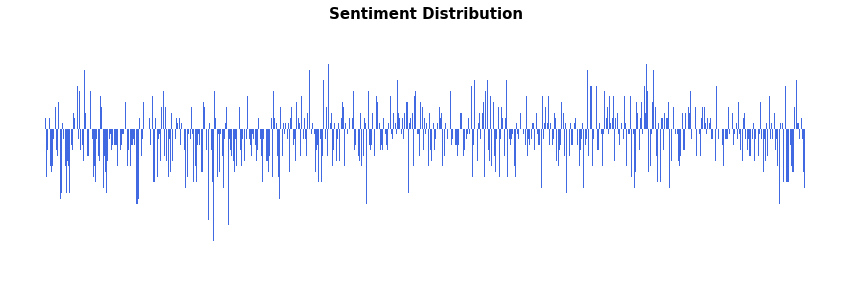

In [19]:
plt.figure(figsize=(15, 5))
plt.bar(range(len(sentiment_score_10)), sentiment_score_10, color = 'royalblue')
frame1 = plt.gca()
frame1.axis('off')
plt.title('Sentiment Distribution', fontdict=font)
plt.show();

In [20]:
## Most positive and negative sentence

most_pos = df.Sentiment_Score.argmax()
most_neg = df.Sentiment_Score.argmin()
print('Most positive sentence:')
print(df.OriginalTweet.iloc[most_pos])
print('-'*50)
print('Most negative sentence:')
print(df.OriginalTweet.iloc[most_neg])

Most positive sentence:
@Tesco really impressed with tesco at haddington Scotland. Hand sanitizer available at entrance with opportunity to clean trolley handles. Staff polite friendly and giving sound guidance to shoppers to shop safely. Well done and thank you ?#staysafe #coro
--------------------------------------------------
Most negative sentence:





  World people  -- panic, panicking, panicked, panicked..


### Classification

#### 5 classes

In [29]:
sentiment_encode= {'Positive':1, 'Negative':2, 'Neutral':3,
                   'Extremely Positive':4, 'Extremely Negative':5}
y = df.Sentiment.replace(sentiment_encode)
print(y.value_counts(normalize=True))

tweet_train, tweet_test, y_train, y_test = train_test_split(df.Tweet_filtered, y, test_size=.2, 
                                                                stratify=y, random_state=123)

1    0.276616
2    0.245248
3    0.178580
4    0.162806
5    0.136749
Name: Sentiment, dtype: float64


In [30]:
pipe_lgbc = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=10, max_df=.3)),
    ('lgbc', LGBMClassifier())
])

param_grid_lgbc = {'lgbc__n_estimators':[200, 400],
                   'lgbc__max_depth':[100, 200]}

gs_pipe_lgbc = GridSearchCV(pipe_lgbc, param_grid_lgbc, cv=3, n_jobs=-1).fit(tweet_train, y_train)

{'lgbc__max_depth': 100, 'lgbc__n_estimators': 200}
0.58
Accuracy Score:0.61


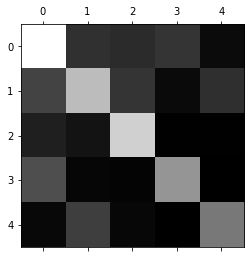

In [31]:
print(gs_pipe_lgbc.best_params_)
print(gs_pipe_lgbc.best_score_.round(2))

y_predict = gs_pipe_lgbc.best_estimator_.predict(tweet_test)
print(f'Accuracy Score:{accuracy_score(y_test, y_predict):.2f}')
conf_mx = confusion_matrix(y_test, y_predict)
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

#### 3 classes

In [25]:
sentiment_encode= {'Positive':1, 'Negative':-1, 'Neutral':0}
y_3 = df.Sentiment_3.replace(sentiment_encode)
print(y_3.value_counts(normalize=True))

tweet_train_3, tweet_test_3, y_train_3, y_test_3= train_test_split(df.Tweet_filtered, y_3, test_size=.2, 
                                                                stratify=y_3, random_state=123)

 1    0.439422
-1    0.381997
 0    0.178580
Name: Sentiment_3, dtype: float64


--------------------------------------
Current n_estimators: 501


,scores
Validation,0.758637
Test,0.751638


--------------------------------------
Current n_estimators: 768


,scores
Validation,0.777197
Test,0.778870


--------------------------------------
Current n_estimators: 1178


,scores
Validation,0.791745
Test,0.801582


--------------------------------------
Current n_estimators: 1807


,scores
Validation,0.799881
Test,0.812203


--------------------------------------
Current n_estimators: 2772


,scores
Validation,0.798638
Test,0.816610


--------------------------------------
Current n_estimators: 4251


,scores
Validation,0.795616
Test,0.815028


--------------------------------------
Current n_estimators: 6520


,scores
Validation,0.790220
Test,0.808588


--------------------------------------
Current n_estimators: 10000


,scores
Validation,0.781576
Test,0.799209


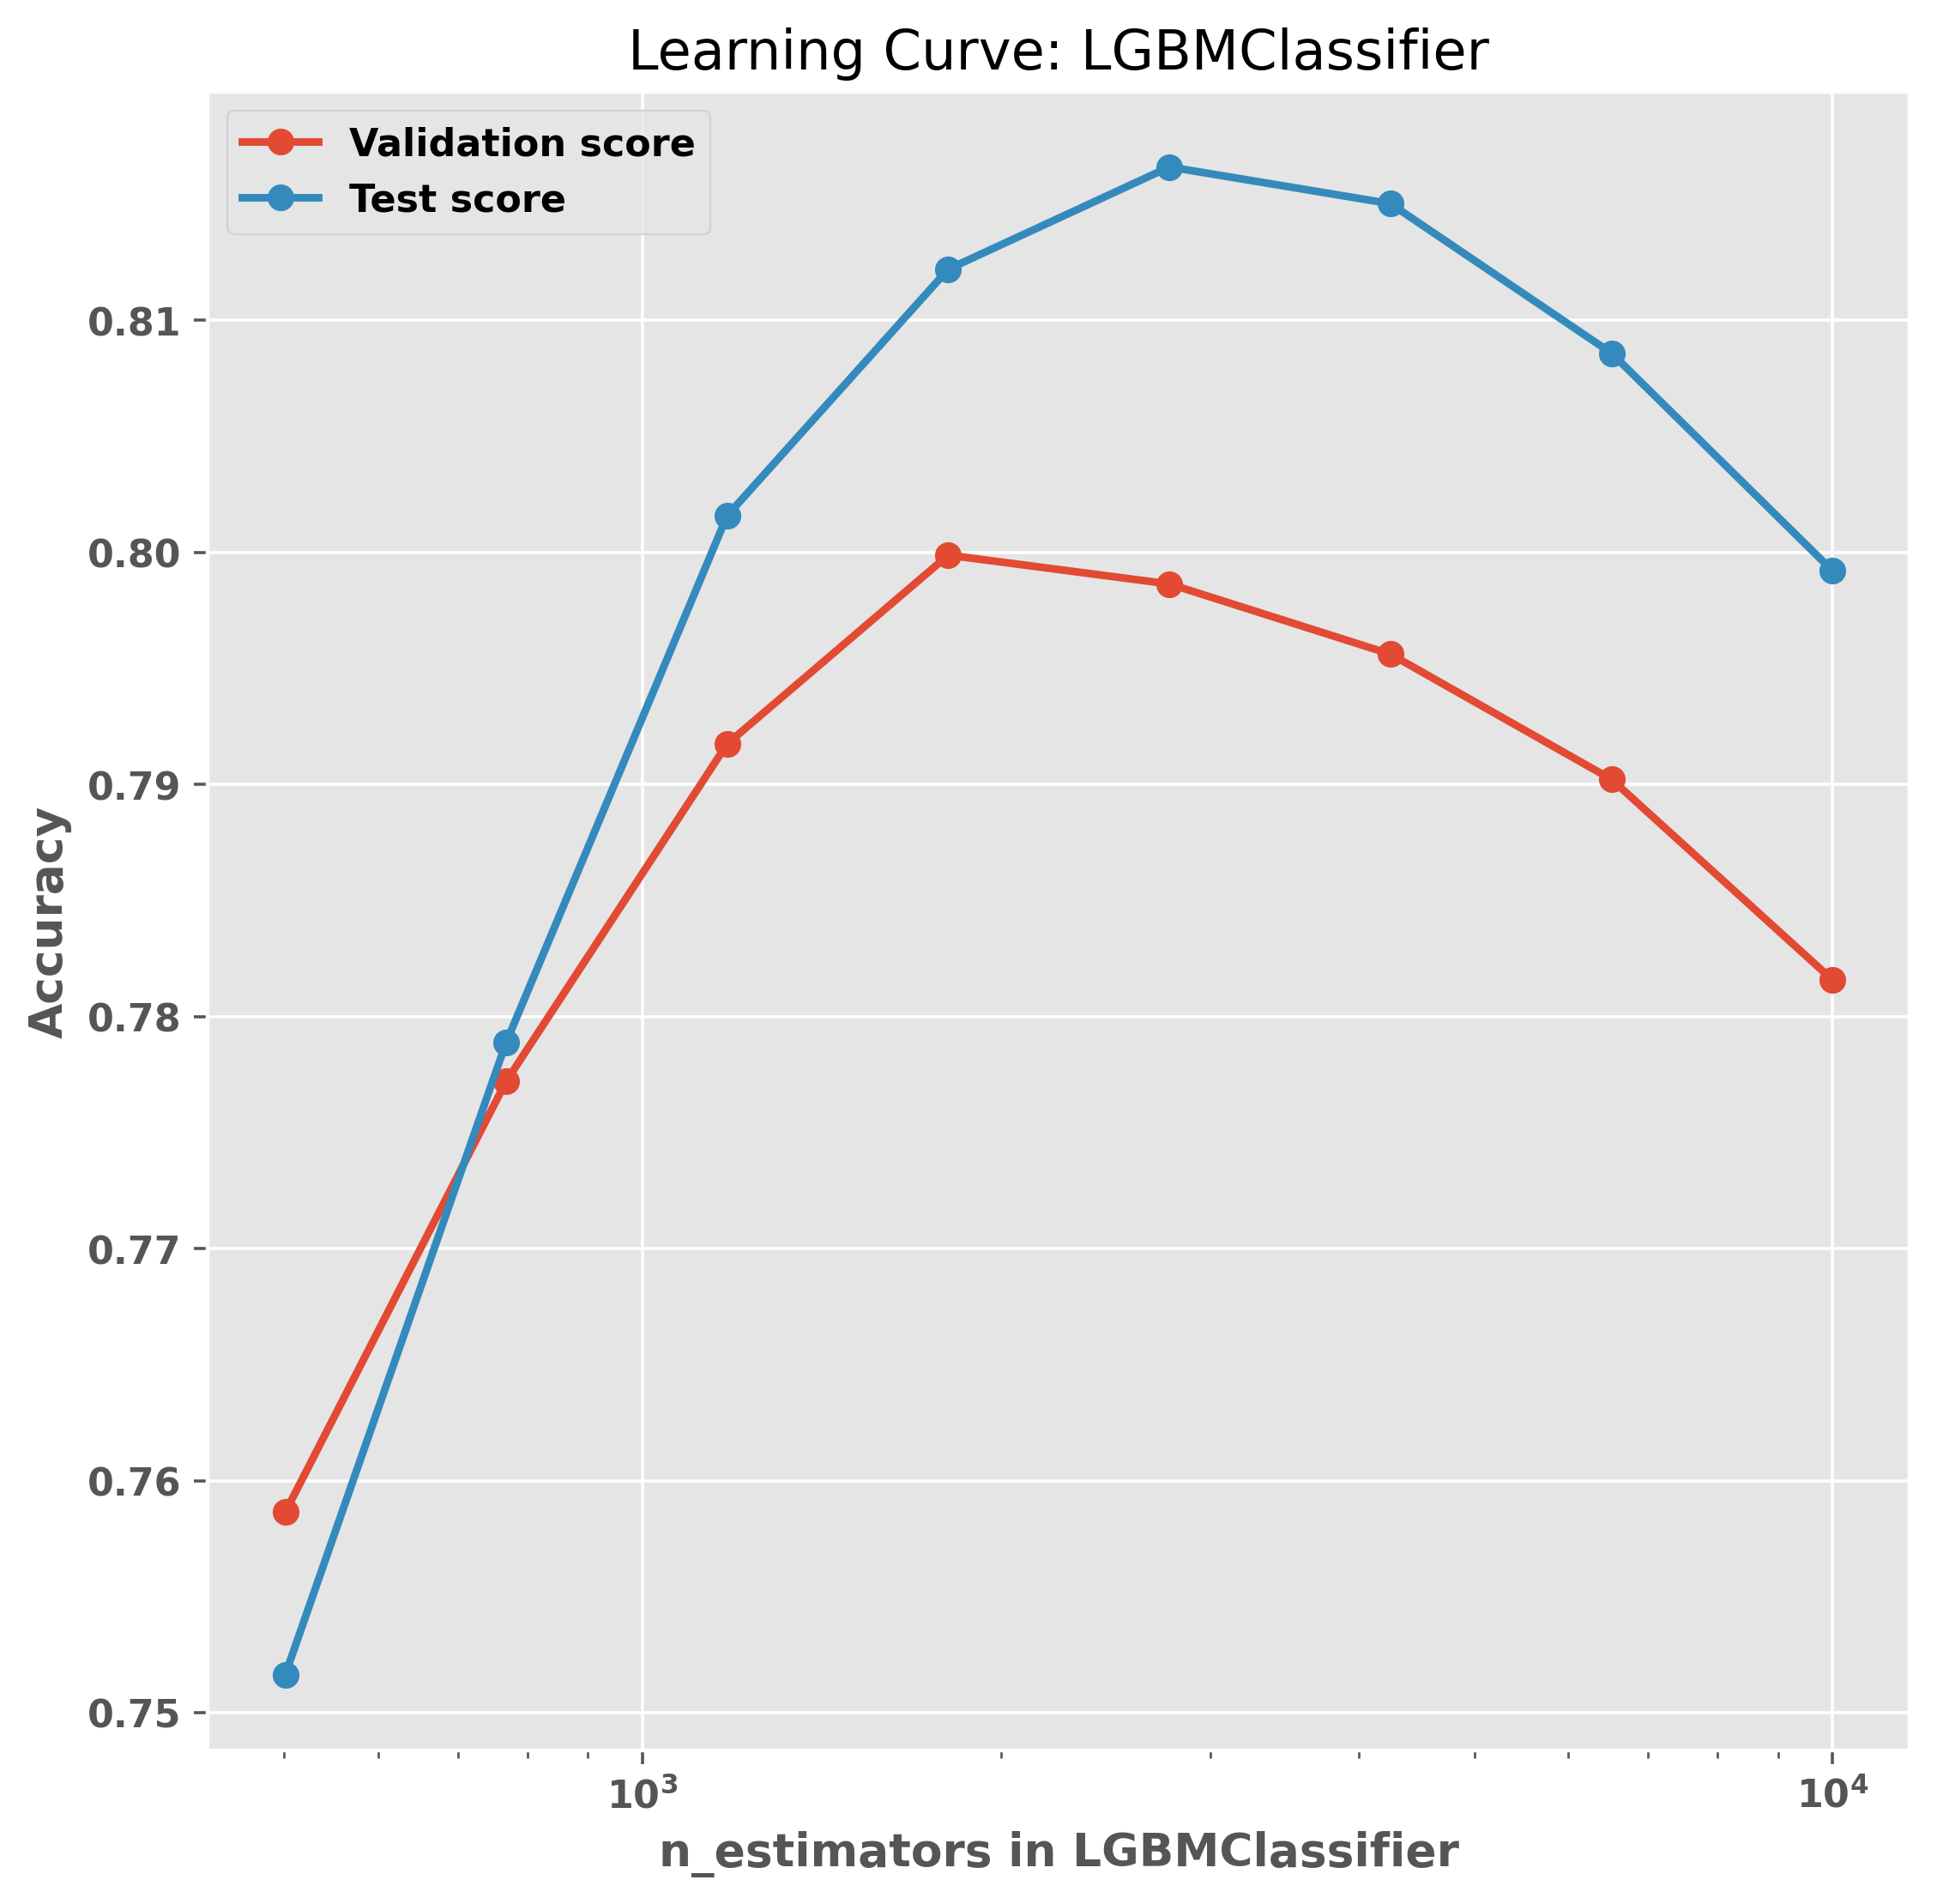

In [24]:
n_estimators_list = [int(item) for item in np.logspace(2.7, 4, num = 8)] # ver2

def get_validation_test_score_list(n_estimators_list):
    validation_error_list = []
    test_error_list = []
    for value in n_estimators_list:
        print(f'--------------------------------------')
        print(f'Current n_estimators: {value}')
        pipe_lgbc = Pipeline([
            ('tfidf', TfidfVectorizer()), 
            ('lgbc', LGBMClassifier())
        ])
        
        param_grid_lgbc = {
            'tfidf__min_df':[10],
            'tfidf__max_df':[0.3],
            'lgbc__n_estimators':[value],
            'lgbc__max_depth':[-1], 
            'lgbc__learning_rate':[0.01], 
            'lgbc__n_jobs':[-1], 
            'lgbc__random_state':[42], 
            'lgbc__importance_type':['gain']
        }

        gs_pipe_lgbc = GridSearchCV(
            pipe_lgbc, 
            param_grid_lgbc, 
            scoring = 'accuracy',
            cv = 5, 
            n_jobs = -1, 
            verbose = 0, 
            return_train_score = True
        ).fit(tweet_train_3, y_train_3)


        clf = gs_pipe_lgbc.best_estimator_
        cv_result = gs_pipe_lgbc.cv_results_
        temp_test_score = clf.score(tweet_test_3, y_test_3)
        # temp_best_index = gs_pipe_lgbc.best_index_
        temp_best_validation_score = gs_pipe_lgbc.best_score_
        # temp_best_validation_score = cv_result['mean_test_score'][temp_best_index]
        temp_best_params = gs_pipe_lgbc.best_params_

        result_df = pd.DataFrame(
            data = [[temp_best_validation_score],
                    [temp_test_score]], 
            columns = ["scores"], 
            index = ["Validation", "Test"]
        )
        display(result_df)

        validation_error_list.append(temp_best_validation_score)
        test_error_list.append(temp_test_score)
    return n_estimators_list, validation_error_list, test_error_list

def plot_learning_curve(n_var_list, validation_score_list, test_score_list):
    plt.style.use('ggplot')
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    fig, ax = plt.subplots(1, 1, figsize = (8, 8), dpi = 320)
    ax.plot(n_var_list, validation_score_list, 'o-', label = "Validation score", linewidth = 2)
    ax.plot(n_var_list, test_score_list, 'o-', label = "Test score", linewidth = 2)
    ax.legend()
    ax.set_xscale("log")
    ax.set_title('Learning Curve: LGBMClassifier')
    ax.set_xlabel('n_estimators in LGBMClassifier')
    ax.set_ylabel('Accuracy')
    plt.show()
    pass

n_estimators_list, validation_error_list, test_error_list = get_validation_test_score_list(n_estimators_list)
plot_learning_curve(n_estimators_list, validation_error_list, test_error_list)

Test Accuracy:0.7924


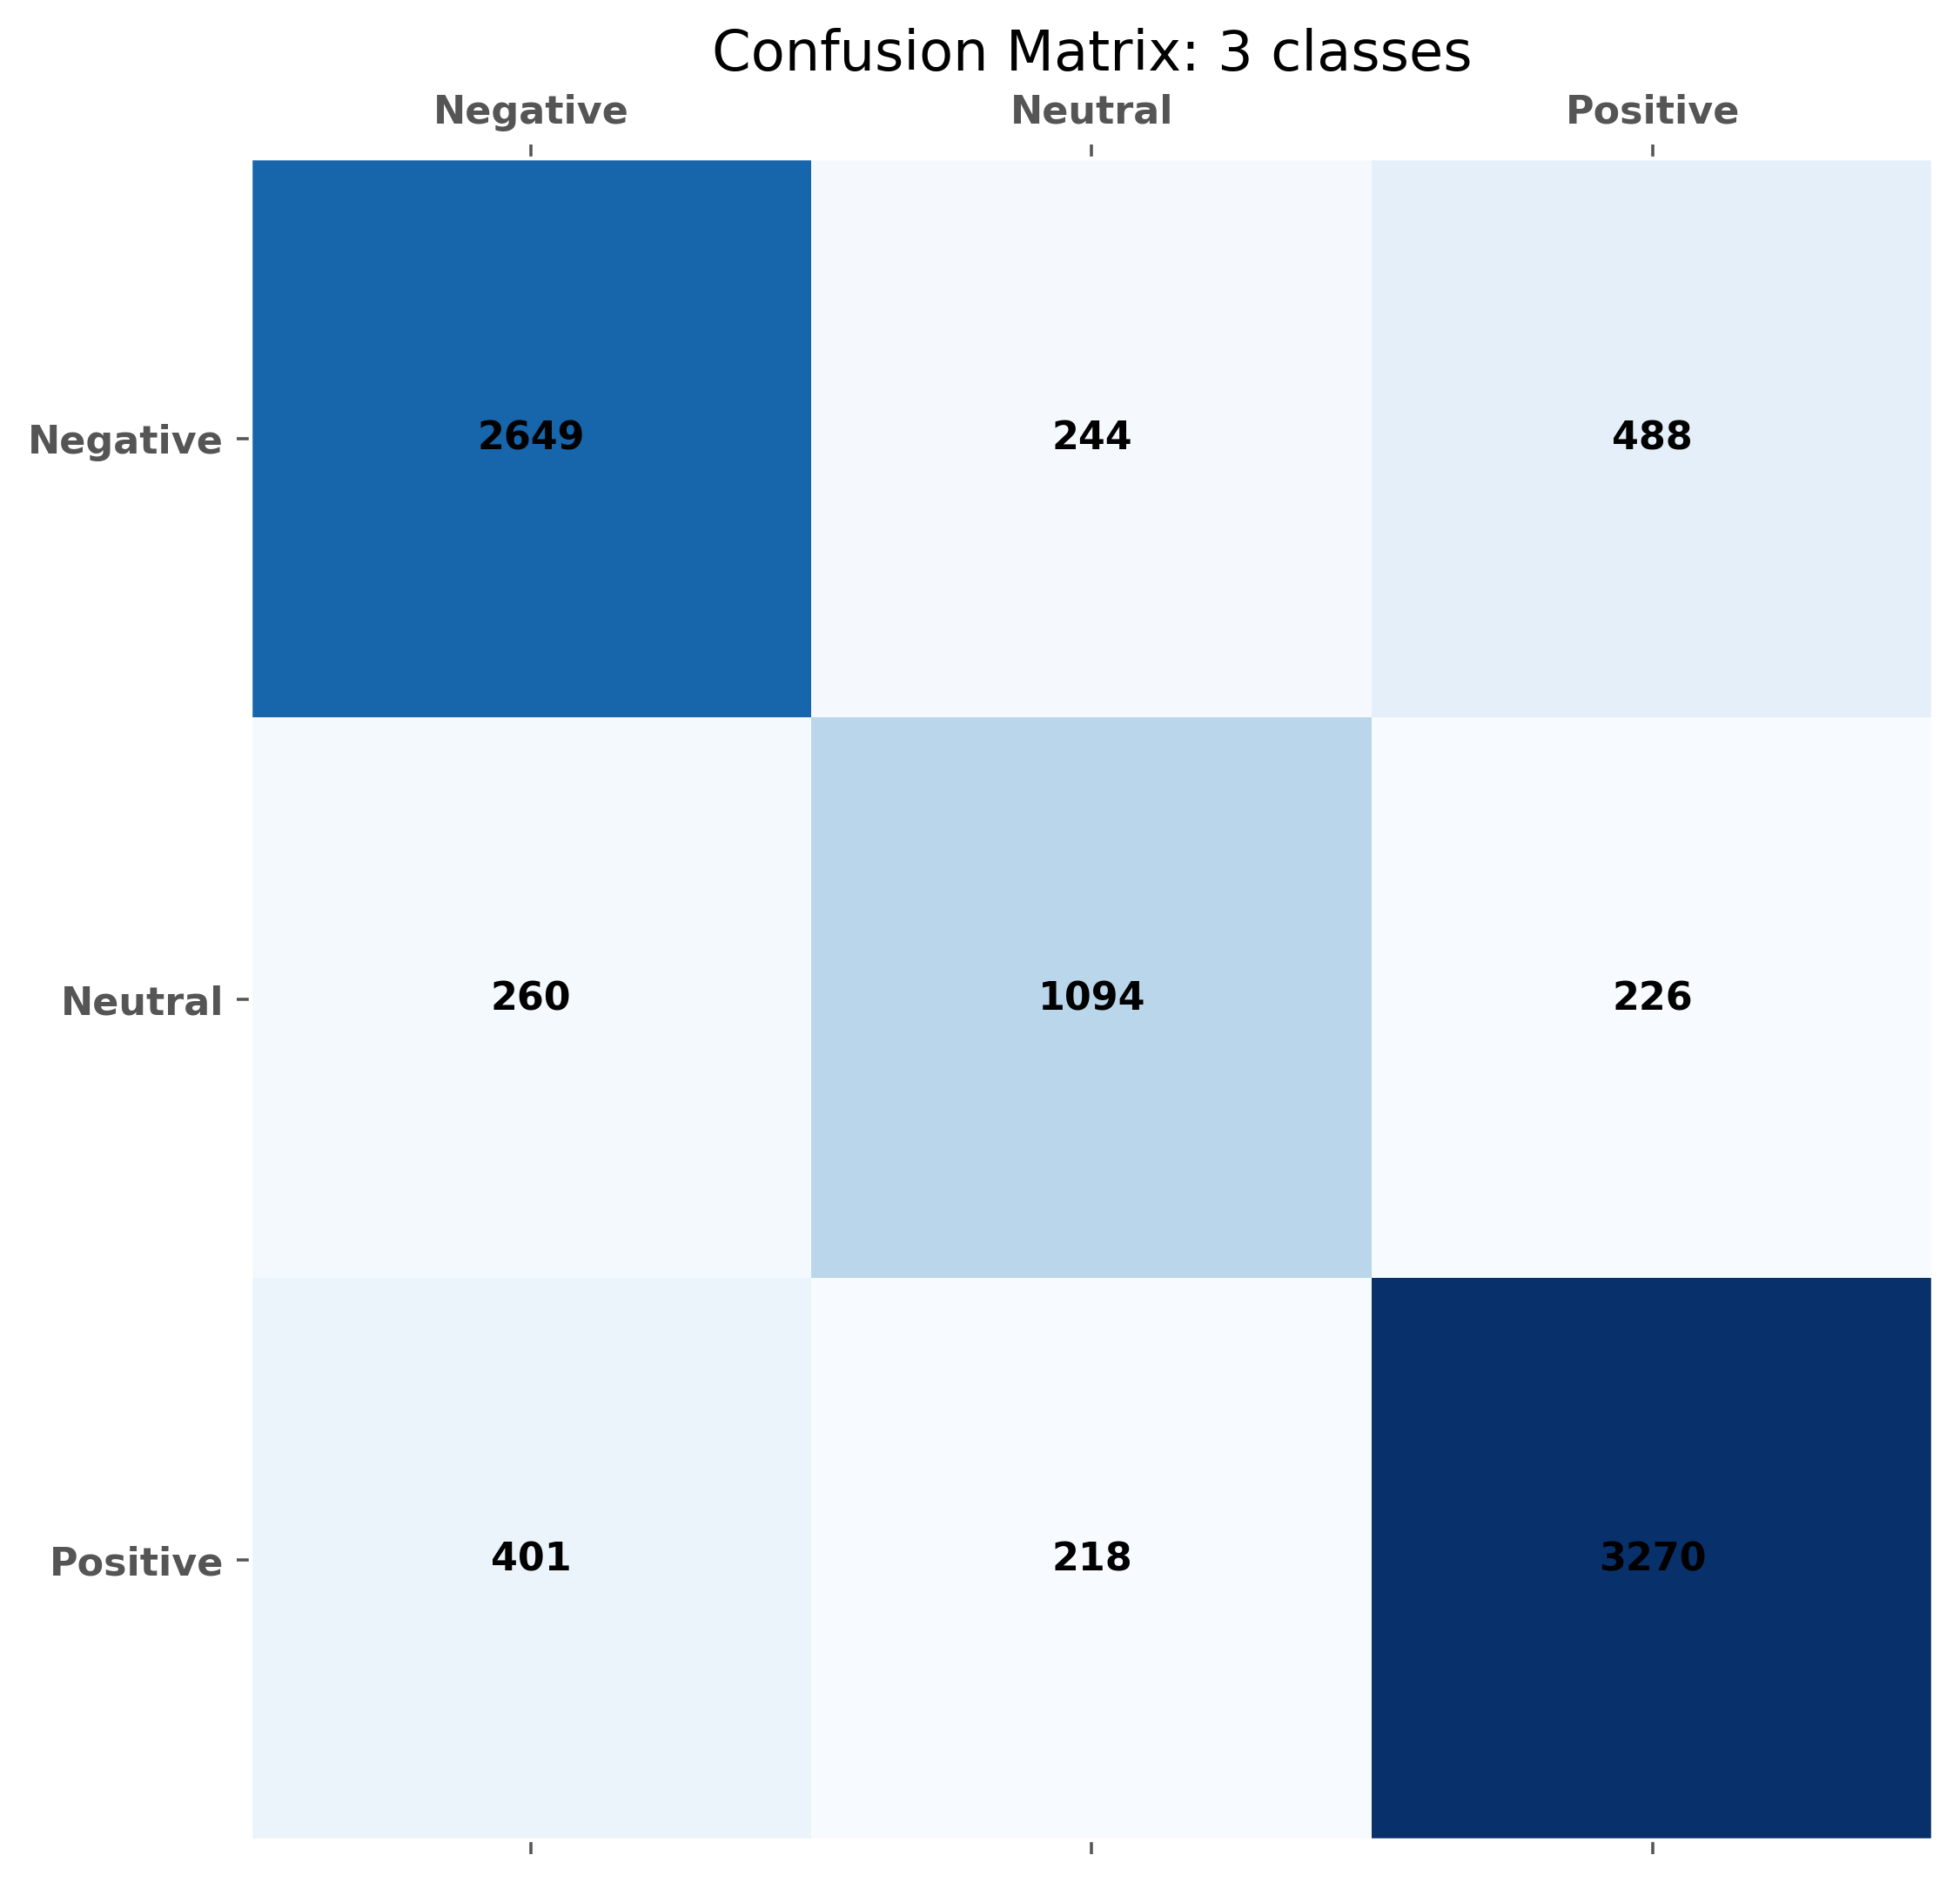

In [41]:
## 1000 estimators

pipe_lgbc_3 = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=10, max_df=.3)),
    ('lgbc', LGBMClassifier(n_estimators=1000, n_jobs=-1, random_state=42))
])

pipe_lgbc_3.fit(tweet_train_3, y_train_3)
y_predict_3 = pipe_lgbc_3.predict(tweet_test_3)
print(f'Test Accuracy:{accuracy_score(y_test_3, y_predict_3):.4f}')
my_cmap = cm.get_cmap('Blues')
fig, ax = plt.subplots(1,1, figsize = (8,8), dpi = 320)
conf_mx = confusion_matrix(y_test_3, y_predict_3)
ax.matshow(conf_mx, cmap = my_cmap)
# Loop over data dimensions and create text annotations.
for i in range(3):
    for j in range(3):
        text = ax.text(j, i, conf_mx[i, j],
                ha = "center", 
                va = "center", 
                color = "black"
            )
ax.grid(False)
ax.set_xticks(np.arange(3), labels = ["Negative", "Neutral", "Positive"])
ax.set_yticks(np.arange(3), labels = ["Negative", "Neutral", "Positive"])
ax.set_title("Confusion Matrix: 3 classes")
plt.show()

Test Accuracy:0.8127


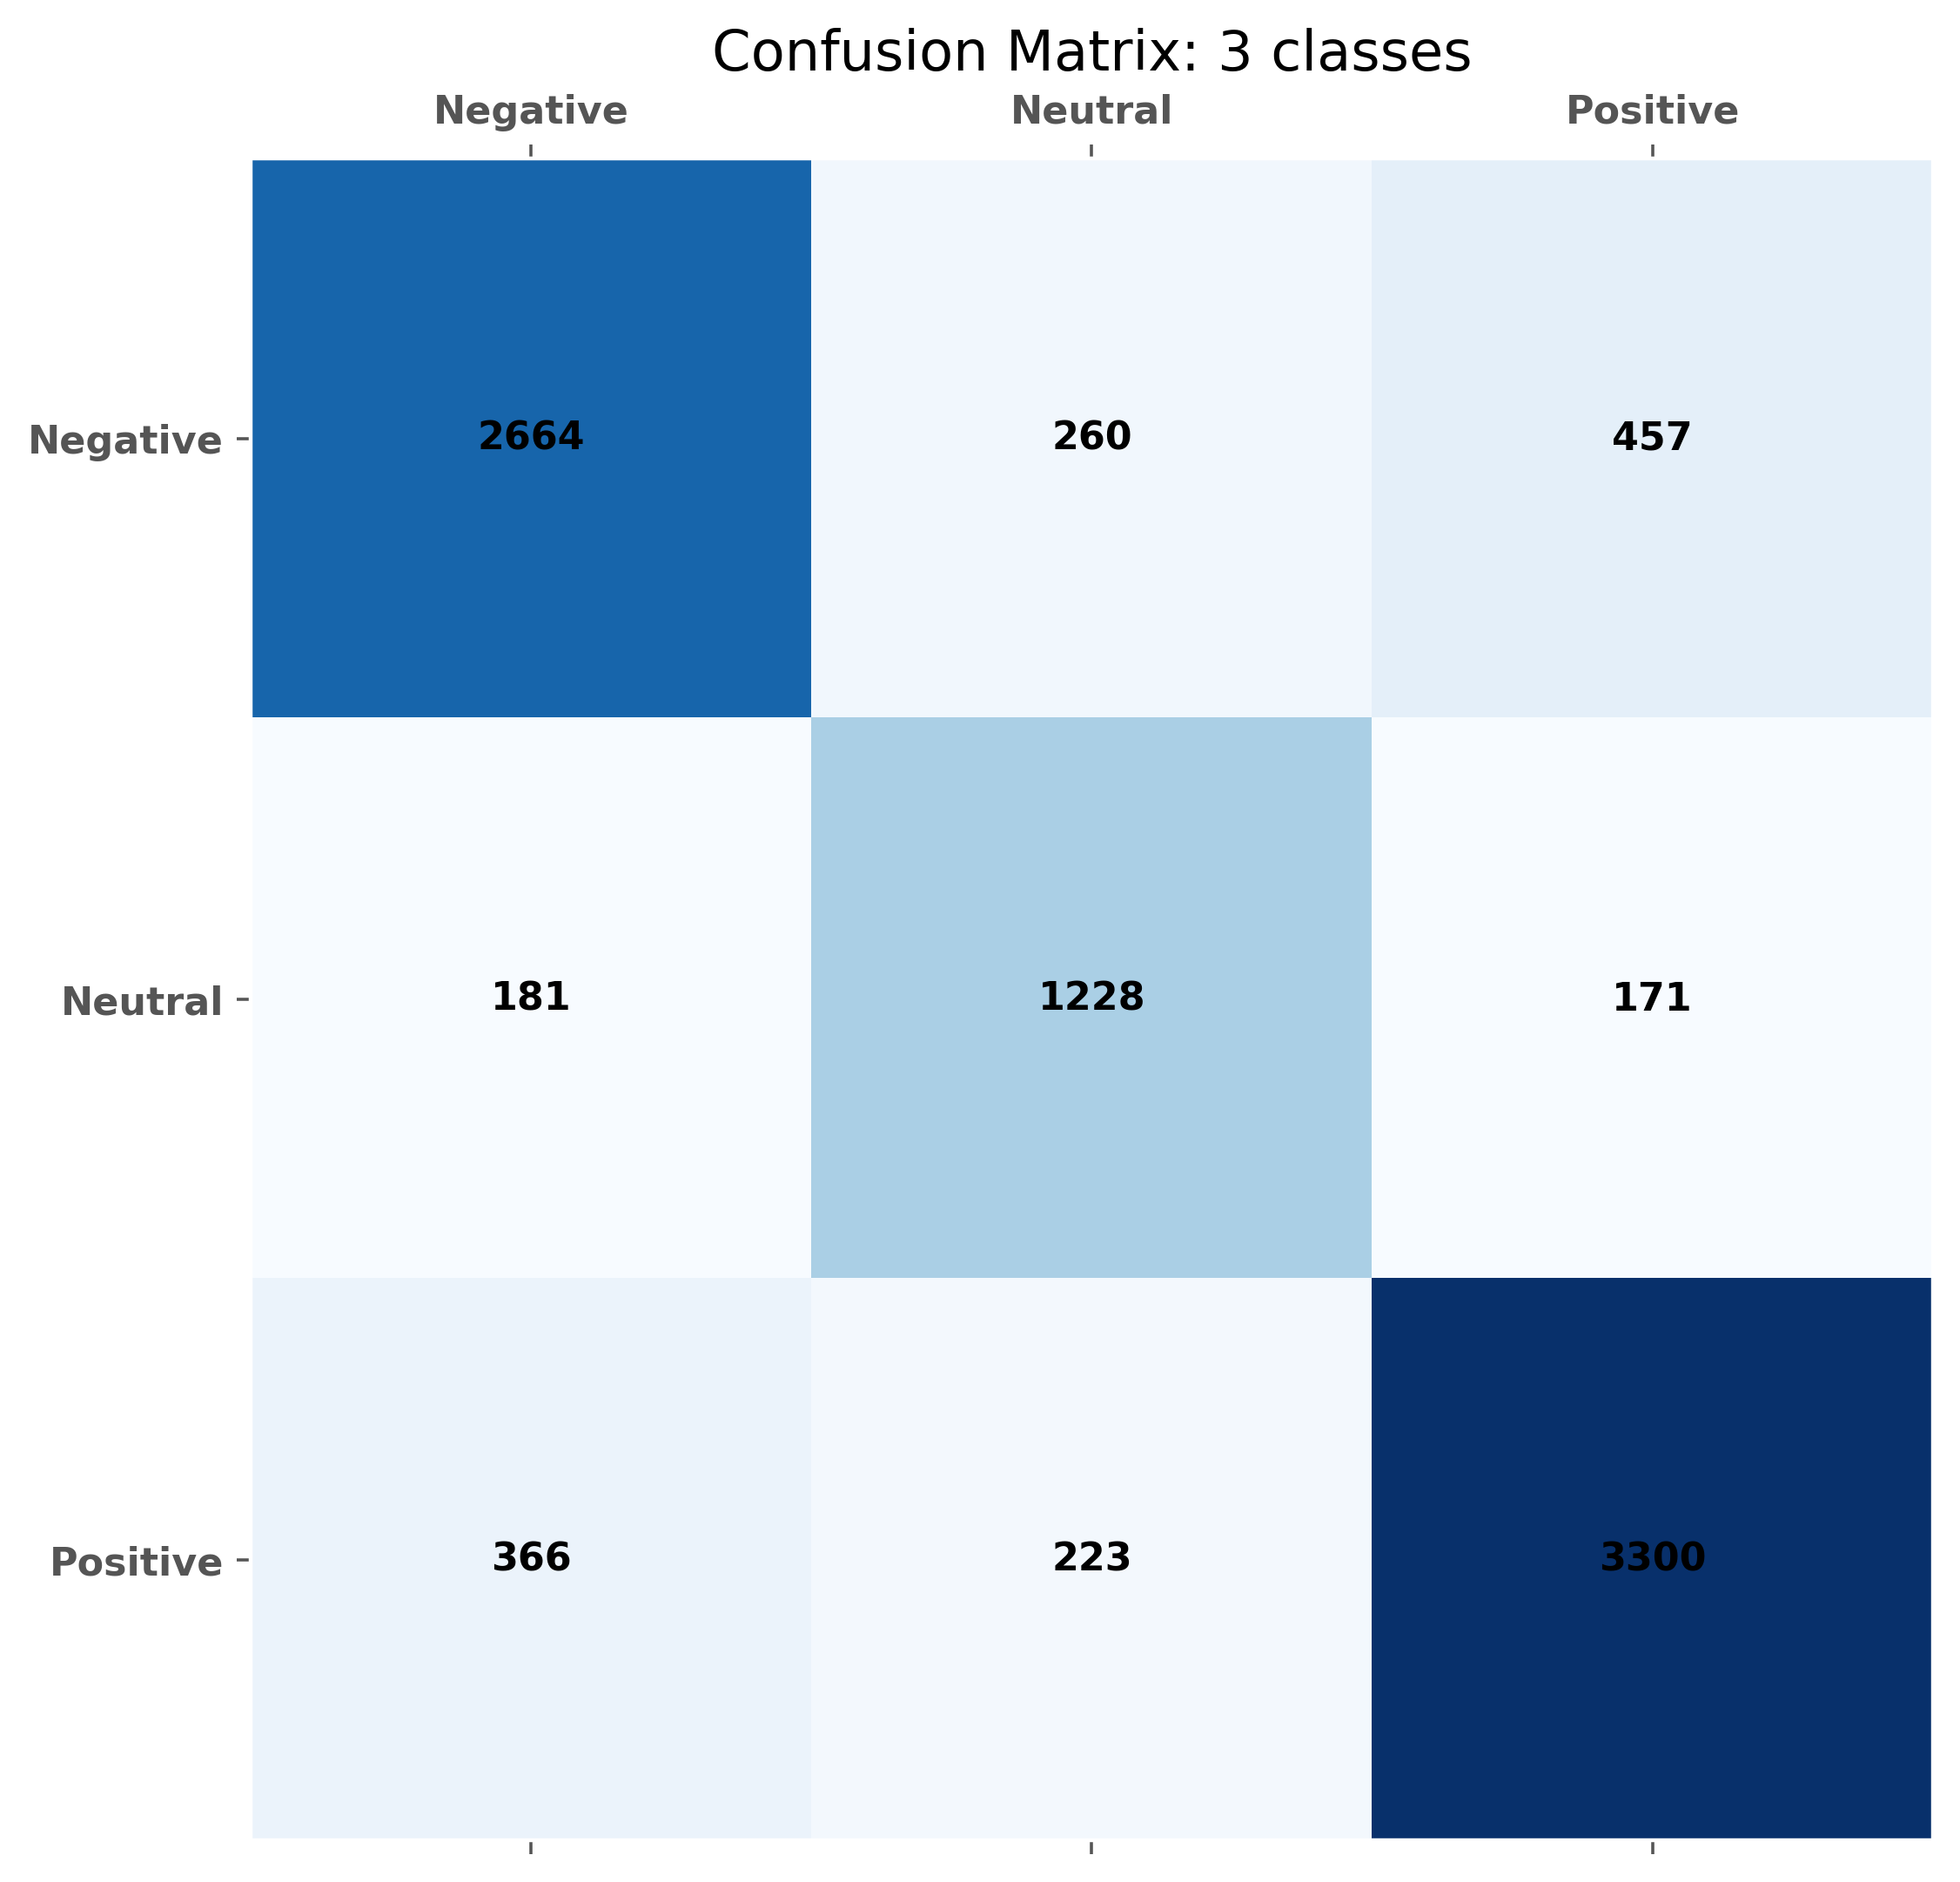

In [40]:
## 200 estimators and default learning rate

pipe_lgbc_3 = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=10, max_df=.3)),
    ('lgbc', LGBMClassifier(n_estimators=200, n_jobs=-1, random_state=42))
])

pipe_lgbc_3.fit(tweet_train_3, y_train_3)
y_predict_3 = pipe_lgbc_3.predict(tweet_test_3)
print(f'Test Accuracy:{accuracy_score(y_test_3, y_predict_3):.4f}')
my_cmap = cm.get_cmap('Blues')
fig, ax = plt.subplots(1,1, figsize = (8,8), dpi = 320)
conf_mx = confusion_matrix(y_test_3, y_predict_3)
ax.matshow(conf_mx, cmap = my_cmap)
# Loop over data dimensions and create text annotations.
for i in range(3):
    for j in range(3):
        text = ax.text(j, i, conf_mx[i, j],
                ha = "center", 
                va = "center", 
                color = "black"
            )
ax.grid(False)
ax.set_xticks(np.arange(3), labels = ["Negative", "Neutral", "Positive"])
ax.set_yticks(np.arange(3), labels = ["Negative", "Neutral", "Positive"])
ax.set_title("Confusion Matrix: 3 classes")
plt.show()

## 6. Word2Vec

In [41]:
model = Word2Vec(sentences=df.Word_list, vector_size=300, workers=1, seed=0)
model.wv.most_similar("food")

[('basic', 0.6782804727554321),
 ('pet', 0.6746236085891724),
 ('household', 0.6685872077941895),
 ('pantry', 0.6660727262496948),
 ('item', 0.6511135101318359),
 ('struggling', 0.6478644013404846),
 ('donate', 0.6416241526603699),
 ('able', 0.6378616094589233),
 ('necessity', 0.6300645470619202),
 ('essential', 0.629356324672699)]

In [43]:
# Create Document Vectors from Word Embedding
def vectorize(list_of_docs, model):
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(df.Word_list, model=model)
print(len(vectorized_docs), len(vectorized_docs[0]))

44249 300


In [ ]:
ssd = []
for i in range(1,20):
    ssd.append(KMeans(n_clusters=i).fit(vectorized_docs).inertia_)

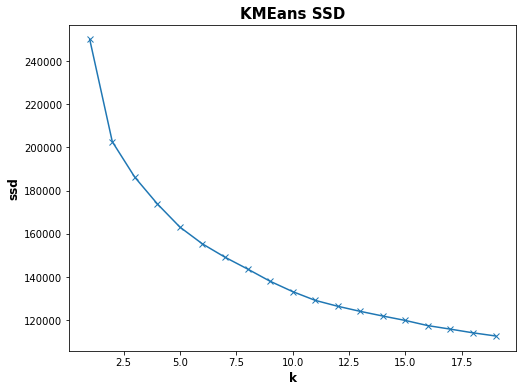

In [52]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
plt.plot(range(1,20),ssd,marker='x'); 
plt.title('KMEans SSD', fontdict = font);
plt.xlabel('k', fontdict = font1);
plt.ylabel('ssd', fontdict = font1);

## 7. LDA

In [56]:
tfidf = TfidfVectorizer(max_df=.3, min_df=15, ngram_range=[1, 2], stop_words='english')
df_tfidf = tfidf.fit_transform(df['Tweet_filtered'])

def lda_ex(number_topic):
    lda = LatentDirichletAllocation(n_components=number_topic, n_jobs=-1, random_state=123)
    df_lda = lda.fit_transform(df_tfidf)
    vocab = tfidf.get_feature_names()
    vocab = [x.replace(' ', '_') for x in vocab]

    for topic_idx, topic in enumerate(lda.components_):
        statement = 'Topic {:#2d}: '.format(topic_idx)
        statement += ' '.join([vocab[i] for i in np.argsort(topic)[:-10-1:-1]])
        print(statement)

numbers = [5, 7, 8, 10]

for number in numbers:
    print(f'Modeling {number:d} topics:')
    lda_ex(number)
    print('_'*50)

Modeling 5 topics:
Topic  0: store grocery food grocery_store supermarket panic people toiletpaper toilet paper
Topic  1: supermarket shopping store online grocery grocery_store people online_shopping home stay
Topic  2: price oil oil_price consumer market gas pandemic impact global economy
Topic  3: price sanitizer consumer hand hand_sanitizer mask scam amp product help
Topic  4: food worker consumer demand store online grocery pandemic amp retail
__________________________________________________
Modeling 7 topics:
Topic  0: food panic supermarket people buying stock shelf panic_buying need store
Topic  1: store supermarket hand sanitizer grocery shopping online hand_sanitizer people stay
Topic  2: price oil oil_price consumer market gas pandemic economy impact demand
Topic  3: consumer price food help demand scam amp bank mask pandemic
Topic  4: worker store grocery consumer employee grocery_store supermarket food staff amp
Topic  5: toiletpaper paper grocery grocery_store toilet st